In [241]:
import pandas as pd
import pickle
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib import colormaps
import os
from tqdm import tqdm
import re

In [3]:
embeddings = pd.read_pickle("/shared/3/projects/benlitterer/podcastData/embeddings/floydMonth/robertaEmbeddings.pkl")
podData = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEnSHORT.csv",lineterminator='\n')

/tmp/ipykernel_3239048/3863807009.py:2: DtypeWarning: Columns (6,7,8,12,20,49) have mixed types. Specify dtype option on import or set low_memory=False.
  podData = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEnSHORT.csv",lineterminator='\n')


In [4]:
#get function to give transcript file path of urls
spec=importlib.util.spec_from_file_location("getURLstorageLocation","/home/blitt/projects/podcasts/mergeTransMetadata/getURLstorageLocation.py")
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)

#get path to transcripts for each url 
META_PATH= "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth"
podData = podData.dropna(subset=["enclosure"])
podData["transcriptPath"] = podData["enclosure"].apply(foo.getUrlTranscriptPath, args=[META_PATH])

In [21]:
#we can only work with the data for which we have transcripts/embeddings 
podData["exists"] = podData["transcriptPath"].apply(os.path.exists)
podData = podData[podData["exists"] == True]

In [42]:
#let's merge the podcast text into the data 
def getTranscripts(inPaths): 
    textDict = {}
    for path in tqdm(inPaths): 
        with open(path, "r") as handle: 
            currText = "".join([row.split(",")[4] for row in handle.readlines()])
            textDict[path] = currText
    return textDict

#transList = getTranscripts(podData["transcriptPath"]) 
textDict = getTranscripts(podData.sample(10000)["transcriptPath"]) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 220.06it/s]


In [62]:
textDf = pd.DataFrame.from_dict(textDict, orient="index", columns=["content"]).reset_index(names=["transcriptPath"])
podData = pd.merge(podData, textDf, on="transcriptPath", how="left") 

In [55]:
embeddings["embeddingsNp"] = embeddings["embedding"].apply(lambda x: x.numpy())

In [56]:
embeddingsMat = np.array(embeddings["embeddingsNp"].tolist()).squeeze()

In [57]:
embeddingsMat.shape

(316065, 768)

In [58]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
pca = PCA(n_components=2)

In [59]:
#lFacs = svd.fit_transform(embeddingsMat)
lFacs = pca.fit_transform(embeddingsMat)

In [60]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

[0.30672861 0.10581211]
[2.16038623 0.74526802]


In [212]:
facsDf = pd.concat([embeddings[["transcriptPath"]], pd.DataFrame(lFacs, columns=["l1", "l2"])], axis=1)
facsDf = pd.merge(podData[["title", "epTitle", "category1", "language", "transcriptPath", "epDescription", "content"]], facsDf, how="right", on="transcriptPath") 
catMeans = facsDf[["category1", "l1", "l2"]].groupby("category1").agg(np.mean)

In [12]:
#catMeans["l2"] = catMeans["l2"].apply(lambda x: np.power(x + 100, 1/20))
#catMeans["l1"] = catMeans["l1"].apply(lambda x: np.power(x + 100, 1/20))

(-0.5, 1.2)

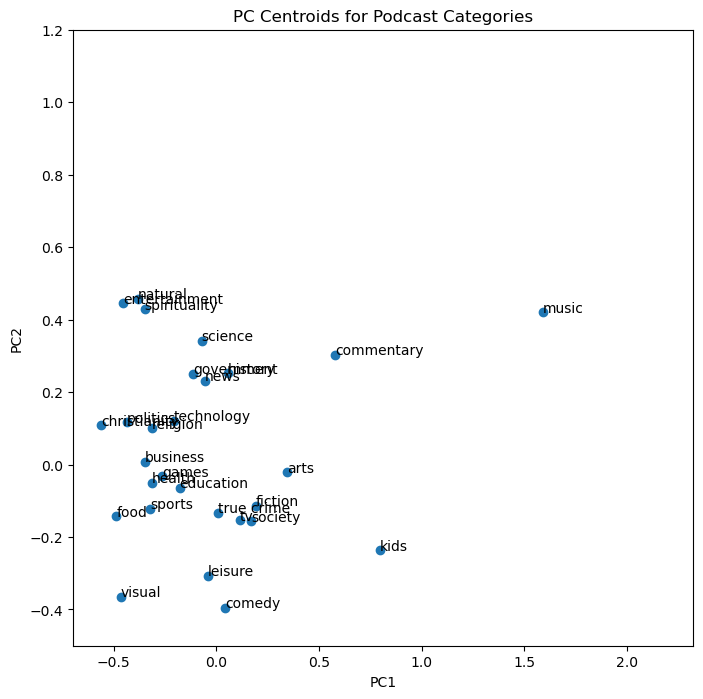

In [280]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(catMeans["l1"], catMeans["l2"])

for i, row in catMeans.iterrows(): 
    ax.annotate(i, (row["l1"], row["l2"]), rotation=0)

ax.set_title("PC Centroids for Podcast Categories")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
#ax.set_xlim(-.5, .8)
ax.set_ylim(-.5, 1.2)

In [234]:
#what are the major words associated with different quadrants of the pca plot? 
contentDf = facsDf[facsDf["content"].isna() == False]
contentDf["contentShort"] = contentDf["content"].apply(lambda x: x[:1000]) 

/tmp/ipykernel_3239048/3104116960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contentDf["contentShort"] = contentDf["content"].apply(lambda x: x[:1000])


In [216]:
#get percentiles of our PC plot 
l1vals = facsDf["l1"]
l2vals = facsDf["l2"]
PC1percentiles = [min(l1vals), np.percentile(l1vals, 33), np.percentile(l1vals, 66), max(l1vals)]
PC2percentiles = [min(l2vals), np.percentile(l2vals, 33), np.percentile(l2vals, 66), max(l2vals)]

In [217]:
print(PC1percentiles)
print(PC2percentiles)

[-1.9323805570602417, -0.6938032960891723, -0.3640976679325102, 6.993165016174316]
[-3.199568271636963, -0.22963374912738796, 0.13026318967342376, 5.78861665725708]


In [218]:
inRange.columns

Index(['epTitle', 'category1', 'language', 'transcriptPath', 'epDescription',
       'content', 'l1', 'l2', 'contentShort'],
      dtype='object')

In [271]:
#high pc1 is just music 
#low pc1 has lot's of "Welcome" 
pc1Range = [-.5, 0]
inRange = contentDf.loc[(contentDf["l1"] > -5) & (contentDf["l1"] < 1) & (contentDf["category1"] == "comedy")]


#print(list(inRange.sort_values("l1", ascending=False)["contentShort"])[14])
inRange.sample(120)[["title", "epTitle", "content", "l1"]].head(20)

title  \
107008                                   CriseD   
280729                The Lay and  Say Podcast!   
264256  Alles Wat Mal is with CHRISTIAN BENNETT   
25017                             Who Hurt You?   
167988                         Arbitrary Advice   
172777               Do It All Dad Year Podcast   
101144                       From Mount Olympus   
23665                                    IDIOMS   
226520                      El comienzo de esto   
7713                        This Week With Drew   
298598             Quarantine for Your Thoughts   
34833                                     S.N.P   
248581                   myMORNINGS - Good Bits   
126314                       INSIDE WESTMINSTER   
181617                        The Saunders Show   
162677       Dave Ryan Show's Minnesota Goodbye   
79086                That's Good Sports Podcast   
270569                     Nonsense News Nation   
226000                         The LSB Mic Show   
114893                    Monster Mates Podcast   

                                                  epTitle  \
107008                               Just recap of mi day   
280729                        Episode 4-WOULD YOU RATHER!   
264256       Alles wat Mal 'everything what arr Mad' TEST   
25017                       Chic-Fil-a Sauce is THE sauce   
167988                 Episode 41: Don’t Be A Petty Patty   
172777                               Lit on Shabbat Again   
101144                                      Ranting Much?   
23665   Idioms with David Dyer - Episode 1 - 2 Birds, ...   
226520                             El comienzo de esto...   
7713    This Week With Drew The Monday Edition - May 1...   
298598                                          Episode 5   
34833                                        We're back 😐   
248581                                  June 02 Good Bits   
126314                Chapter 162 - 'Some Brutal Truths'    
181617     Strangest and craziest ways people have died!!   
162677               The Time You Put Your Life in Danger   
79086   XFL Sale, Hockey to Return & MY HUGE ANNOUNCEM...   
270569             10: Justice League Gets the Snyder Cut   
226000                                  Black Revolution    
114893                              Episode 13: Imp Girls   

                                                  content        l1  
107008  content *sad music* That's right" you know it'...  0.547807  
280729  content [Music] Alright" welcome back to the f... -0.720996  
264256  content On Okay" so technical for technical te... -0.414699  
25017   content [Music] Hey guys" welcome back to Who ... -1.135343  
167988  content Hey guys" this is P from arbitrary adv... -0.813074  
172777  content [Music] Chapter 4 lit on Shabbat again... -0.387980  
101144  content (upbeat music) What it do ladies and g... -0.651845  
23665   content Hey everybody this is David Dyer and w... -0.512230  
226520  content [ Sansa's turn and she's protecting me... -0.246224  
7713    content Do do do do do do do do do do do do do... -0.533773  
298598  content [Music] Hello. Oh" that's my light. Ar... -0.686861  
34833   content [Music] We're back. Welcome. [Laughter... -0.343159  
248581  content My morning's with Nick and Sean on 996... -1.031538  
126314  content [Music] Queen's-side Westminster" chap... -0.420798  
181617  content Hello everyone welcome back to anythin... -0.773385  
162677  content I swear to God your breakfast smells l... -0.422358  
79086   content Welcome to that's good sports. I am Br... -0.338329  
270569  content *Intro* Welcome back ladies and gentle... -0.619191  
226000  content So what on who the fuck do we call? So... -0.812334  
114893  content Hello everyone and welcome to the next... -0.917215

In [252]:
#hypothesis: we have more personal, "I" language in low pc1 
def countIs(inStr): 
    return len(re.findall("I ", inStr))

#testStr = " I don't know how I feel about all of this" 
contentDf["ICount"] = contentDf["contentShort"].apply(countIs)

/tmp/ipykernel_3239048/1862458045.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contentDf["ICount"] = contentDf["contentShort"].apply(countIs)


In [257]:
np.corrcoef(contentDf["l1"], contentDf["ICount"]) 

array([[ 1.        , -0.29430944],
       [-0.29430944,  1.        ]])

In [258]:
contentDf["l1Quant"] = pd.qcut(contentDf["l1"], 3)

/tmp/ipykernel_3239048/2026641414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contentDf["l1Quant"] = pd.qcut(contentDf["l1"], 3)


Text(0.5, 1.0, "Introductions with higher values of pc1 seem more 'personal'")

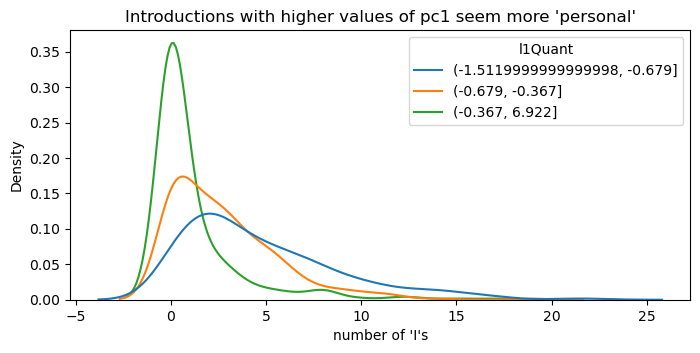

In [275]:
fig, ax = plt.subplots(figsize=(8, 3.5))
sns.kdeplot(data=contentDf.sample(1000), x="ICount", hue="l1Quant", ax=ax, common_norm=False)
ax.set_xlabel("number of 'I's") 
ax.set_title("Introductions with higher values of pc1 seem more 'personal'") 

In [171]:
#iterate through bottom of range's 
for i in range(len(PC1percentiles)-1): 
    #for j in tqdm(range(len(PC2percentiles)-1)): 
    tfidf = TfidfVectorizer(max_features=10000, max_df=.1, min_df=5) 
    
    #specificy ranges 
    pc1Low = PC1percentiles[i]
    pc1High = PC1percentiles[i + 1]
    pc2Low = PC2percentiles[j]
    pc2High = PC2percentiles[j + 1]

    print(f"PC1 range: {pc1Low},{pc1High}")
    print(f"PC2 range: {pc2Low},{pc2High}")
    
    #subset in two steps for readability 
    currRows = contentDf[(contentDf["l1"] > pc1Low) & (contentDf["l1"] < pc1High)]
    #currRows = currRows[(currRows["l2"] > pc2Low) & (currRows["l2"] < pc2High)]

    #get tfidf scores 
    tfScores = tfidf.fit_transform(currRows["contentShort"])
    featureNames = tfidf.get_feature_names_out()

    tfIdfSums = np.sum(tfScores, axis=0).tolist()[0]
    sumFrame = pd.DataFrame({"vocab":featureNames, "scores":tfIdfSums}).sort_values("scores", ascending=False).head(20)
    print(sumFrame["vocab"].head(30))

PC1 range: -1.9323805570602417,-0.6938032960891723
PC2 range: 0.13026318967342376,5.78861665725708
913            he
2150         week
1978        thank
1308      morning
854           god
665     everybody
2218         yeah
1191          lot
857         gonna
1175           ll
1306         more
1821    something
1700          say
908           has
1357          new
862           got
891           had
1168    listening
961          hope
1775         show
Name: vocab, dtype: object
PC1 range: -0.6938032960891723,-0.3640976679325102
PC2 range: 0.13026318967342376,5.78861665725708
1128          he
1438        life
1055         god
2689        week
2426        talk
2222        show
2628        very
1630        more
1464          ll
2664        want
1052          go
591        covid
2705        when
393         care
17            19
265      because
1279        into
1701          no
1632     morning
841     everyone
Name: vocab, dtype: object
PC1 range: -0.3640976679325102,6.993165016174316

In [146]:
tfIdfSums = np.sum(tfScores, axis=0).tolist()[0]

In [149]:
pd.DataFrame({"vocab":featureNames, "scores":tfIdfSums}).sort_values("scores", ascending=False).head(20)

vocab      scores
9961       yeah  312.463795
3960        god  281.837204
8062        she  210.746857
4320        his  208.827534
9462     upbeat  169.008564
4310        him  162.911726
6689    podcast  160.441073
5377       love  153.777988
4278        her  145.260901
6175       okay  139.499592
3511       feel  135.097498
6170         oh  133.153068
3972      gonna  131.107332
5565       mean  131.089023
4892      jesus  122.473189
9904      world  116.553587
4113       guys  115.004215
2661  different  113.535343
501          am  112.541168
4042      great  111.902397

In [70]:


tfidf = TfidfVectorizer(max_features=10000, max_df=.5, min_df=5) 
tfScores = tfidf.fit_transform(contentDf["content"]) 


In [143]:
facsDf[facsDf["category1"].isin(["comedy", "government"])]

epTitle category1 language  \
36                          It Started with a Door Handle    comedy       en   
37      It's like being a Yankees fan from Central Ill...    comedy       en   
92      A Fine Print Review of 'The Last Dance' Ep 9.-...    comedy       en   
93      A Fine Print Review: 'The Last Dance' with Ant...    comedy       en   
142                                     RamCast Episode 5    comedy    en-us   
...                                                   ...       ...      ...   
326793               4.11 - The Secret Ingredient of Chez    comedy       en   
326794   A RandomBush Minicast: Wild Tangent's #64 - B...    comedy       en   
326795  4.10 - The Brown Power Ranger,  Fermentation, ...    comedy       en   
326796   A RandomBush Minicast: Wild Tangent's #63 - W...    comedy       en   
326797          4.09 - Sir, You Are Scaring the Children!    comedy       en   

                                           transcriptPath        l1        l2  
36      /shared/3/projects/benlitterer/podcastData/pro... -0.688335 -0.391747  
37      /shared/3/projects/benlitterer/podcastData/pro... -0.627128 -0.494700  
92      /shared/3/projects/benlitterer/podcastData/pro... -0.626272 -0.311273  
93      /shared/3/projects/benlitterer/podcastData/pro... -0.898188 -0.901824  
142     /shared/3/projects/benlitterer/podcastData/pro... -0.662441 -0.588038  
...                                                   ...       ...       ...  
326793  /shared/3/projects/benlitterer/podcastData/pro... -0.883403 -0.147131  
326794  /shared/3/projects/benlitterer/podcastData/pro... -0.474839  0.075863  
326795  /shared/3/projects/benlitterer/podcastData/pro... -0.572972 -0.128646  
326796  /shared/3/projects/benlitterer/podcastData/pro... -0.807270 -0.223252  
326797  /shared/3/projects/benlitterer/podcastData/pro... -0.573551 -0.276566  

[13272 rows x 6 columns]

<Axes: xlabel='l1', ylabel='l2'>

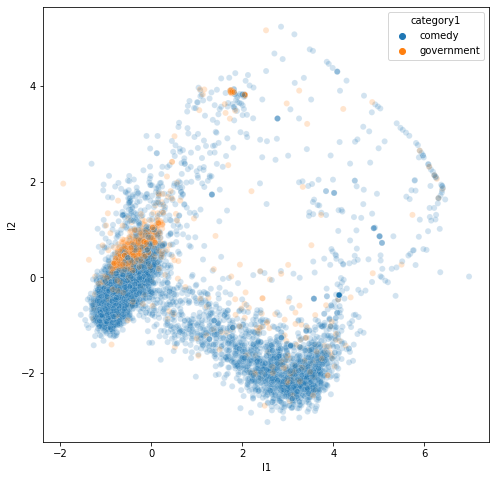

In [145]:
#[facsDf["category1"].isin(["comedy", "government"])]
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=facsDf.sample(8000), x="l1", y="l2", hue="category1", alpha=.2, ax=ax)
#plt.xlim(-2, 1.5)
#plt.ylim(-1.5, 2)

In [161]:
list(facsDf.loc[facsDf["l1"] > 1.75, "epDescription"].sample(20).dropna())

['  Listen to my newest episode and discover more great content from my show!  ',
 'Fgjjjkkkhjj',
 'Music from the sanctuary on May 24, 2020. Hugh Hinton on organ and piano, and the songleader is Mike Rodehorst.',
 "<p><strong>Carry Minati's YouTube vs TikTok: The End video where he roasted TikToker Aamir Siddiqui went viral like wildfire. Yet, quickly Amir Siddiqui made a reply video where he accused Carry Minati of harassment and bullying.</strong></p><p><strong>He described Youtuber's roast video, which made with an intention to bully and spread hate against Amir Siddiqui. Thoughts of Carry Minati pushing Amir Siddiqui towards suicide via the roast video also surfaced. However, the Carry Minati roast video was soon reported by many people who support Amir Siddiqui and YouTube took it down.</strong></p><p><strong>Yes, the TikTok vs YouTube video where Carry Minati had roasted Aamir Siddiqui has been removed for breaching community guidelines.</strong></p>--- Support this podcast: <a 